# Introduction

Ce notebook fait suite au notebook 1 qui nous a permis de sélectionner les datasets les plus appropriés à notre tâches de classification et aussi de mieux comprendre l'impact des divers hyper-paramètres sur une architecture classique comme LeNet.

N'ayant pu atteindre un niveau de perfomance adéquat dans un temps raisonnable, nous allons cette fois nous pencher sur un modèle de transfer learning en utilisant une architecture **VGG16** avec les poids d'**imagenet**, un dataset d'images génériques.

Nous allons procéder en trois temps:


1.   Efectuer un entrainement de test sur une portion limitée du dataset pour évaluer le choix ne nos hyper-paramètres initiaux.
2.   En se basant sur l'évaluation du permier test, lancer un entrainement sur les données complètes
3. Ré-entrainer les 4 dernières couches de VGG16 pour tenter d'ajuster au plus près les poids de la partie extraction de features de notre modèle



# Initialisation

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/MyDrive/nov23_bds_rakuten


In [ ]:
random_state = 42
output_dir = "output/data-modeling-images-3"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
import keras.saving

from keras.utils import to_categorical
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Librairie de fonctions

Bien que je préfère en général définir les fonctions au fur et à mesure de leur utilisation, la multiplication des stratégies que nous allons tester rend plus simple de les rassembler dans cette section. En les extrayant du déroulement de chaque stratégie, nous pourrons plus efficacement dupliquer et identifier leur trame commune.

## Import des données


Commençons par définir une fonction **import_images** qui permet d'importer le jeu d'images que l'on souhaite utiliser.

In [ ]:
def import_images(zip_path,dest_dir):
    image_path = dest_dir
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile(zip_path,"r") as images_zip:
            images_zip.extractall(image_path)
    image_path = image_path + "/images"
    return image_path

## Rapport de modèle

Avant de commencer à créer notre modèle, nous allons nous occuper de comment on pourra comparer les différentes stratégies que nous allons tester.

Nous allons créer un dataframe **df_reporting** qui contiendra les informations pertinentes sur notre stratégie de modélisation ainsi que ses résultats:
* Un nom et un id de modèle
* Les sources de données utilisées ainsi que la taille du subset de données.
* Les hyper-paramètres du modèle
* L'état en cours de l'entraînement ainsi que le nombre d'époques à atteindre
* Les métriques de performance de l'entraînement, la validation et des tests.

Au fur et à mesure de nos tests, on veillera à sauvegarder ce dataframe dans un fichier **model_reporting.csv**. Ce fichier nous assurera qu'on puisse reprendre nos tests là où ils se sont arrêtés en cas d'interruption. Dans ce cas, on veillera également à sauvegarder l'état des modèles ayant la meilleure performance, afin de compléter l'entraînement sur les époques manquantes.

Plus tard, le fichier **model_reporting.csv** nous servira aussi à comparer les modèles de chaque notebook de modélisation. Pour cette raison, on va tenter d'être le plus complet possible dans les informations qu'on y met.



Ajoutons une fonction qui va créer le dataframe **df_reporting** en y ajoutant un modèle d'exemple.


In [ ]:
def create_reporting_df(save=True):
  reporting_df = pd.DataFrame([{
      #model infos
      "model_id":int(0),
      "model_name":"Example model",

      #data sources
      "dataset_source": "output/data-exploration/X_train_pre.csv",
      "dataset_resampled": False,
      "image_dataset_source" : "data/images.zip",
      "image_dataset_zoomed" : False,
      "train_size": int(42458),

      #hyper parameters
      "image_size": int(300),
      "image_color_rgb": True,
      "batch_size":int(32),
      "image_data_generator_params": {"rescale":1./255,"shear_range":0.2,"zoom_range":0.2,"horizontal_flip":True},
      "start_lr": 0.001,
      "last_lr": 0.0001,
      "optimizer": "adam",

      #fit info
      "target_epochs": int(10),
      "last_epoch": int(6),
      "fit_complete": True,

      #metrics
      "f1_score": 0.42,
      "val_f1_score": 0.37,
      "test_f1_score": 0.35,
      "accuracy": 0.57,
      "val_accuracy": 0.39,
      "test_accuracy": 0.41,
      "loss": 1.567,
      "val_loss": 2.657,

      #other
      "remarks": "Ceci n'est pas un vrai modèle. C'est juste un exemple",
  }])

  reporting_df.set_index("model_id",inplace=True)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")
  return reporting_df




Ajoutons également une fonction qui va nous permettre de charger un **model_reporting_df** s'il existe.


In [ ]:
def load_reporting_df():
  return pd.read_csv(output_dir+"/model_reporting.csv",index_col="model_id")

On a besoin d'une fonction pour ajouter une nouvelle ligne dans **reporting_df**.

In [ ]:
def add_reporting_line(model_id:int,model_name:str,save:bool=True):
  reporting_df.loc[int(model_id),"model_name"] = str(model_name)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction pour ajouter ou modifier des informations dans notre modèle. On veillera à ce que cette fonction sauvegarde automatiquement le dataframe dans **model_reporting.csv**. On a besoin de garder le maximum d'informations en cas d'interruption.

In [ ]:
def update_reporting_line(model_id: int,d:dict={},save:bool=True):
  for key in d.keys():
        reporting_df.at[int(model_id), str(key)] = d.get(key)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction **get_reporting_value** qui permette de récupérer une information stockée pour un modèle.

In [ ]:
def get_reporting_value(model_id,key,default=None):
  try:
    value = reporting_df.at[model_id,key]
    if np.isnan(value):
      value=None
  except KeyError:
    value=None

  if value == None and default != None:
      value=default
  return value

## Création du modèle

Ajoutons une fonction **build_model** qui va nous permettre de créer les différentes couches de notre architecture basé sur une combinaison entre:
* **VGG16** avec les poids d'**imagenet** comme extracteur de features
* Un réseau de neurone dense classique qui prend en entrée la sortie de **VGG16** et est chargé de la classification des features

> Note: Pour le moment, on gèle les couches de **VGG16** pour empecher que les poids pré-claclulés d'**imagenet** ne soient modifiés lors de l'entrainenemt.


In [ ]:
def build_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False,input_shape=input_shape)
    for layer in base_model.layers:
      layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=27,activation="softmax"))

    return model

Nous allons également avoir besoin d'une métrique personnalisée **w_f1_score** qui permette de calculer le F1 Score pondéré. On veille à ajouter l'annotation **@keras.saving.register_keras_serializable** pour que Keras ne pose pas de problème lors du chargement du modèle.


In [ ]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

## Sauvegarde du modèle

Toujours en vue d'être résilient par rapport aux interruptions qui ont lieu régulièrement lors de la phase d'entraînement du modèle, créons des fonctions qui vont nous permettre de sauvegarder et restaurer un modèle Keras, afin de pouvoir reprendre l'entraînement s'il a été stoppé, ou même d'afficher les métriques d'un modèle dont l'entraînement est complet.


In [ ]:
def load_saved_model(model_id):
  model_path = output_dir+("/model-%d.keras" % model_id)
  model_path_obj = Path(model_path)
  if model_path_obj.exists():
    print("Load previous model from",model_path)
    return load_model(model_path)
  else:
    print("No previous model found at",model_path)
    return None

In [ ]:
def save_model(model_id,model):
  path = output_dir+("/model-%d.keras" % model_id)
  print("save model ",model_id,"to ",path)
  model.save(path)

Comme nous allons afficher des graphiques sur l'évolution des métriques pendant l'entrainement, il nous faut également des fonctions qui nous permettent de sauver, charger un historique

In [ ]:
def load_training_history(model_id):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  history = None
  if Path(path).exists():
    with open(path, "rb") as file:
      history = pickle.load(file)
  return history

In [ ]:
def save_training_history(model_id,history):
  path = output_dir+("/training_history_%d.pkl" % model_id)
  with open(path, "wb") as file:
    pickle.dump(history,file)

Parcequ'un entrainemnt peut être fait en plusieurs fois, nous devons pouvoir concaténer un historique d'entrainement actuel avec le précédent sauvegardé.

In [ ]:
def concat_training_histories(prev_history,actual_history):
  full_history = {}
  for key in actual_history:
    full_history[key]=np.concatenate((prev_history[key],actual_history[key]),axis=0)
  return full_history

In [ ]:
def get_full_training_history(model_id,training_history):
  if training_history == None:
    history = load_training_history(model_id)
  else:
    prev_history = load_training_history(model_id)
    if prev_history != None:
      history = concat_training_histories(prev_history,training_history.history)
    else:
      history = training_history.history
  return history

## Callbacks pour l'entraînement du modèle

La callback **LogBest** va nous permettre de sauvegarder l'état de l'entraînement et les métriques du modèle à la fin de chaque époque.

Seules les meilleures métriques sont sauvegardées. Elles correspondent à la meilleure époque du modèle que nous sauvegardons également. Elles sont donc mises à jour au fur et à mesure de l'entraînement.


In [ ]:
class LogBest(Callback):
    def __init__(self, model_id):
        super().__init__()
        self.model_id = model_id

    def on_epoch_end(self, epoch, logs=None):

        update_reporting_line(self.model_id,{
            'last_epoch': epoch +1, # Epochs are 0-indexed, so we add 1
            'last_lr': float(K.get_value(self.model.optimizer.learning_rate)),
        })

        if float(logs['val_w_f1_score']) <= float(get_reporting_value(self.model_id,"val_f1_score",0.0)):
          return
        print("\nFound better model with val_f1_score=%.2f" % float(logs['val_w_f1_score']))
        update_reporting_line(self.model_id,{
            "f1_score": logs['w_f1_score'],
            "val_f1_score": logs['val_w_f1_score'],
            "accuracy": logs['accuracy'],
            "val_accuracy": logs['val_accuracy'],
            "loss": logs['loss'],
            "val_loss": logs['val_loss'],
        })
        save_model(self.model_id,self.model)


Cette callback nous permet de stopper l'entraînement lorsque le F1 Score ne progresse plus.


In [ ]:
early_stopping = EarlyStopping(
              monitor='val_w_f1_score',
              mode="max", #stop when f1 score is not increasing anymore
              patience=5,           # Number of epochs with no improvement
              min_delta=1e-2,       # Minimum change to qualify as an improvement
)

## Évaluation du modèle

Ajoutons quelques fonctions qui vont nous faciliter l'affichage de graphiques et de matrices lors de la phase d'évaluation du modèle.


La fonction **plot_training_history** permet d'afficher l'évolution des différentes métriques en suivant le cours des époques de la phase d'entraînement.


In [ ]:
def plot_training_history(history):
  x = range(1,len(history['accuracy']) + 1 )
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.plot(x,history['val_accuracy'],label="val_accuracy")
  plt.plot(x,history['accuracy'],label="accuracy")
  plt.plot(x,history['val_w_f1_score'],label="val_f1_score")
  plt.plot(x,history['w_f1_score'],label="f1_score")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title("Accuracy/f1 evolution during training")
  plt.legend()

  plt.subplot(122)
  plt.plot(x,history['val_loss'],label="val_loss")
  plt.plot(x,history['loss'],label="loss")
  plt.xticks(x)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss evolution during training")
  plt.legend()

  plt.show()


Ici, on récupère du notebook **data-exploration** les labels correspondant aux classes, pour donner plus de lisibilité lors de l'évaluation.


In [ ]:
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant,déguisement",
    1281 : "Jeu société",
    1300 : "Jouet tech",
    1301 : "Jeu intérieur,chaussettes",
    1302 : "Jeu extérieur,vêtement",
    1320 : "Bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues,journaux",
    2403 : "Magazines,livres,BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique,papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

Enfin, ajoutons une fonction **plot_confusion_matrix** qui nous permette d'afficher la matrice de confusion de manière lisible.


In [ ]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(15, 8))
  sns.set(font_scale=0.8)
  classes = [(str(c) +": "+ prdcodetype2label[int(c)]) for c in classes_keras]
  sns.heatmap(cm, annot=True, cbar=True, square=False,fmt='g'
              ,xticklabels=classes,yticklabels=classes)
  plt.xlabel('Prédit')
  plt.ylabel('Réel')
  plt.title('Matrice de confusion')
  plt.show()

# Modélisation 1

Cette première modélisation va servir d'entrainement de test donc les resulats de l'évaluation nous servirons par la suite pour ajuster nos hyper-paramètres à des valeurs adéquates. Nous allons partir sur les bases suivantes:
* Dataset d'image zoomées
* Dataset ré-équilibré
* **batch_size**=64
* **image_size**=224 pour correspondre au format des images avec lesquelles **VGG16** a été entrainé
* Un optmiseur **Adam** avec un learning rate de départ de 0.001

In [ ]:
model_id = 311

## Import des données

On importe donc les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [ ]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

extracting images from drive into colab's session storage... (about 1 min)


On charge maintenant le csv des données ré-équilibrées par le notebook **data_preprocessing_resampling**. Ce notebook étant executé à partir des données en sortie de **data_preprocessing_images**, il contient également la colonne **imagefile**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les trois fichiers qui constituent sa sortie:
* **df_train.csv**: L'ensemble d'entrainement
* **df_val.csv**: L'ensemble de validation
* **df_test.csv**: L'ensemble de test

In [ ]:
df_train = pd.read_csv("output/data-preprocessing-resampling/df_train.csv",index_col=0)
df_val = pd.read_csv("output/data-preprocessing-resampling/df_val.csv",index_col=0)
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv",index_col=0)
df_train.head()

,productid,imageid,text,lang,text_fr,imagefile,prdtypecode
0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,10/image_885888766_product_131641431.jpg,10
1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,10/image_1304710852_product_745789761.jpg,10
2,651353882,1033554185,Lecons De Sciences - Cours Superieur - Premier...,fr,Lecons De Sciences - Cours Superieur - Premier...,10/image_1033554185_product_651353882.jpg,10
3,4043473264,1306457352,Generations Of Women Historians -,en,Générations de femmes historiens -,10/image_1306457352_product_4043473264.jpg,10
4,679913105,1034656535,Oeuvres Dramatiques De F. Schiller Tome 6 -,fr,Oeuvres Dramatiques De F. Schiller Tome 6 -,10/image_1034656535_product_679913105.jpg,10


## Preprocessing

On sépare les variables explicatives de la cible.

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

On applique un traitement similaire à la modelisation 1.3 du permier notebook mais en modifiant **target_train_size** pour ne garder que 20% des données d'entrainement

In [ ]:
target_train_size = int(len(X_train)*0.2)
print("Target train size is",target_train_size)
train_split_rate = (len(X_train) - target_train_size) / len(X_train)
X_train, X_none, y_train, y_none = train_test_split(X_train,y_train,test_size=train_split_rate,random_state = random_state,
                                                    shuffle=True,stratify=y_train)
print("X_train length is now",len(X_train))

Target train size is 21913
X_train length is now 21913


Confirmons que les classes sont toujours équilibrées après la réduction.

In [ ]:
y_train.value_counts()

1160    812
1940    812
2060    812
2582    812
2220    812
50      812
1560    812
40      812
1300    812
1281    812
2585    812
1140    812
1320    812
2522    812
1302    812
10      812
2280    811
2705    811
1180    811
1301    811
1920    811
2403    811
60      811
2583    811
2462    811
2905    811
1280    811
Name: prdtypecode, dtype: int64

C'est bien le cas

On va laisser les set de test et de validation inchangés car ils sont déjà calibré à 10% des données

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.


In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-3/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.37000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
311,Modèle 3.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21913.0,224.0,True,64.0,"{'preprocessing_function': 'preprocess_input',...",...,True,0.552243,0.52043,0.514401,0.558103,0.516927,0.515191,1.433475,1.707712,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.


In [ ]:
add_reporting_line(model_id,"Modèle 3.1")

On peut déjà renseigner les informations sur les données sources qu'on utilise.


In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-exploration/X_train_pre.csv",
    "dataset_resampled": False,
    "image_dataset_source" : "data/images.zip",
    "image_dataset_zoomed" : False,
    "train_size": len(X_train),
})

## Générateurs d'images

Dans cette section, nous allons créer les générateurs qui vont fournir au modèle les images.


Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


Pour le générateur d'entraînement, on réutilise les paramètres de transformations du notebook **data-modeling-images-1** car ils semblent avoir bien fonctionné (on a pas observé d'overfitting lors de nos tests).

On va toutefois modifier **target_img_size** comme annoncé dans le préambule de cette section.

Enfin, nous enlevons le paramètre `rescale=1./255` qu'on remplace par `preprocessing_function=ts.keras.applications.vgg16.preprocess_input`. C'est **preprocess_input** qui se charge de convertir le format d'image en un format compatible avec **VGG16**

In [ ]:
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "preprocessing_function":"preprocess_input",
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})
batch_size=64
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)





Found 21913 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée. On choisit d'utiliser le taux d'apprentissage par défaut (0.001).


In [ ]:
model = load_saved_model(model_id)
start_lr = 0.001
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

Load previous model from output/data-modeling-images-3/model-311.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)           

## Entraînement du modèle

On procède à l'entraînement du modèle uniquement si le rapport nous indique que son entraînement n'est pas fini (colonne **fit_complete**).

Dans le cas de la reprise d'un entraînement interrompu, on reprend l'entraînement pour le nombre d'époques qu'il reste à accomplir pour atteindre le nombre d'époques visé (**target_epochs**).

Une fois l'entraînement terminé, on passe **fit_complete** à **True**.

Les métriques sur la progression de l'entraînement ainsi que les meilleurs modèles sont récoltées et enregistrées dans la callback **LogBest**.

In [ ]:
target_epochs = 10
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

No need to train model


## Évaluation du modèle

Si un entraînement a eu lieu au cours de cette exécution du notebook, on recharge le meilleur modèle qu'on a trouvé.


In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


On teste le modèle sur l'ensemble de test.

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 78s 488ms/step


On doit convertir le résultat de **predict** depuis le format renvoyé par Keras, qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes, en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité maximale de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fournit à Keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

À partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.


In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.5144
accuracy on test dataset=0.5152


Récupérons l'historique d'entraînement complet grâce à **get_full_training_history** qu'on va enregistrer. Puis, affichons deux graphiques :

* L'évolution de l'accuracy et du score F1 en fonction des époques.
* L'évolution des indicateurs de perte **loss** et **val_loss**.


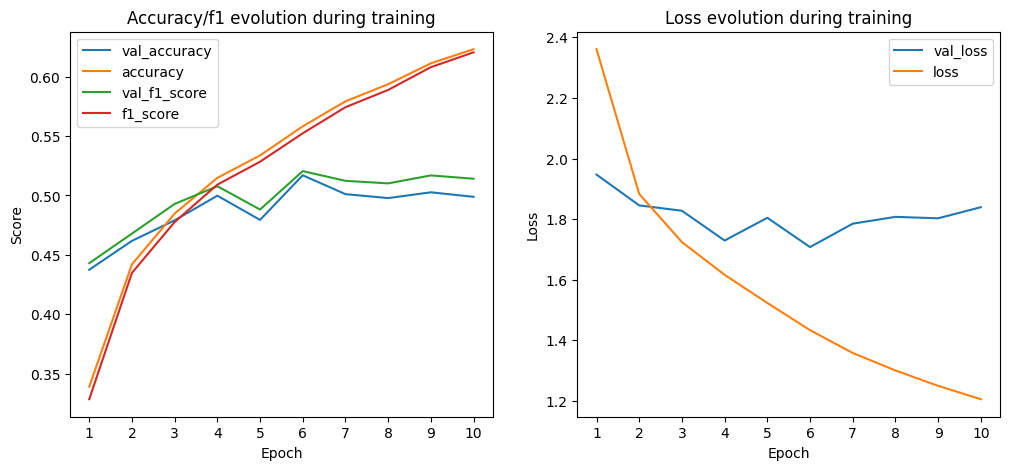

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.


In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.38      0.37      0.38       311
        1140       0.51      0.56      0.53       267
        1160       0.73      0.88      0.80       396
        1180       0.18      0.39      0.25        76
        1280       0.50      0.23      0.31       487
        1281       0.33      0.22      0.27       207
        1300       0.51      0.67      0.58       505
        1301       0.37      0.59      0.45        81
        1302       0.33      0.35      0.34       249
        1320       0.40      0.38      0.39       324
        1560       0.47      0.52      0.50       507
        1920       0.72      0.79      0.75       431
        1940       0.39      0.73      0.50        81
        2060       0.51      0.34      0.41       499
        2220       0.25      0.43      0.31        82
        2280       0.67      0.57      0.62       476
        2403       0.61      0.44      0.51       477
        2462       0.45    

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

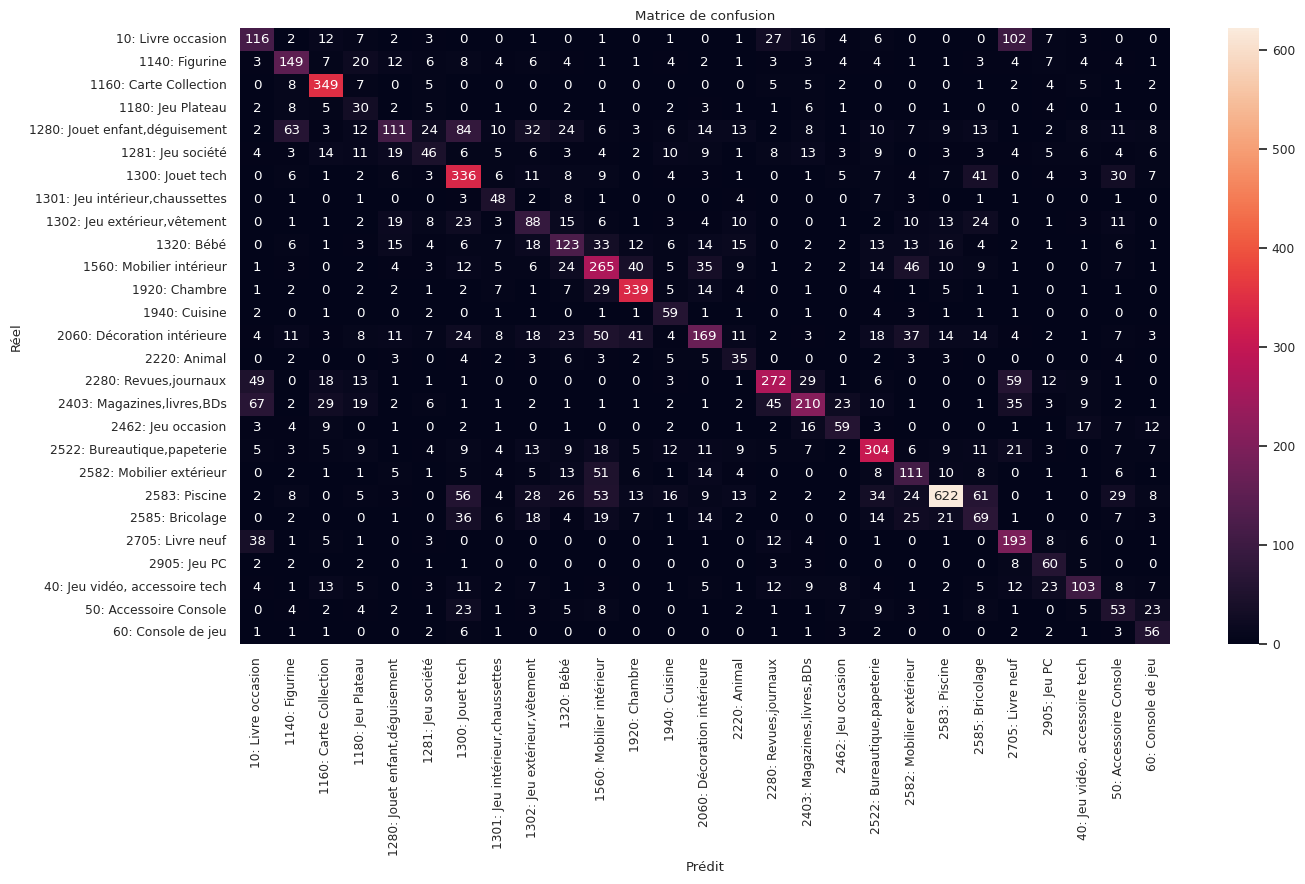

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle.

In [ ]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 3.1
dataset_source                           output/data-exploration/X_train_pre.csv
dataset_resampled                                                          False
image_dataset_source                                             data/images.zip
image_dataset_zoomed                                                       False
train_size                                                               21913.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'preprocessing_function': 'preprocess_input',...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Modélisation 2

Nous avons vu que les paramètres choisis précédemment ont semblé plutôt bien fonctionnée sur un dataset limité à 20% des données. On va donc les réutiliser à plus grande echelle en entrainant le modèle sur toutes les données cette fois ci.

In [ ]:
model_id = 321

## Import des données

On réutilise les données importées dans la modélisation 1

## Preprocessing

On sépare les variables explicatives de la cible.

In [ ]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_validation = df_val.drop("prdtypecode",axis=1)
y_validation = df_val["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

Confirmons que les classes sont bien équilibrées

In [ ]:
y_train.value_counts()

10      4058
1920    4058
2705    4058
2585    4058
2583    4058
2582    4058
2522    4058
2462    4058
2403    4058
2280    4058
2220    4058
2060    4058
1940    4058
1560    4058
40      4058
1320    4058
1302    4058
1301    4058
1300    4058
1281    4058
1280    4058
1180    4058
1160    4058
1140    4058
60      4058
50      4058
2905    4058
Name: prdtypecode, dtype: int64

C'est bien le cas

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.


In [ ]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-images-3/model_reporting.csv


In [ ]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,train_size,image_size,image_color_rgb,batch_size,image_data_generator_params,...,fit_complete,f1_score,val_f1_score,test_f1_score,accuracy,val_accuracy,test_accuracy,loss,val_loss,remarks
model_id,,,,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,300.0,True,32.0,"{'rescale': 0.00392156862745098, 'shear_range'...",...,True,0.420000,0.37000,0.350000,0.570000,0.390000,0.410000,1.567000,2.657000,Ceci n'est pas un vrai modèle. C'est juste un ...
311,Modèle 3.1,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,21913.0,224.0,True,64.0,"{'preprocessing_function': 'preprocess_input',...",...,True,0.552243,0.52043,0.514401,0.558103,0.516927,0.515191,1.433475,1.707712,NaN


Ajoutons une ligne correspondant à notre modèle et commençons à renseigner ses informations.


In [ ]:
add_reporting_line(model_id,"Modèle 3.2")

On peut déjà renseigner les informations sur les données sources qu'on utilise.


In [ ]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-exploration/X_train_pre.csv",
    "dataset_resampled": False,
    "image_dataset_source" : "data/images.zip",
    "image_dataset_zoomed" : False,
    "train_size": len(X_train),
})

## Générateurs d'images

Dans cette section, nous allons créer les générateurs qui vont fournir au modèle les images.


Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [ ]:
classes_keras = list(np.sort(np.array(df_train["prdtypecode"].unique(),dtype="str")))


On réutilise les mêmes paramètres que lors de la modélisation 1

In [ ]:
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

update_reporting_line(model_id, {
    "image_data_generator_params" : {
      "preprocessing_function":"preprocess_input",
      "rotation_range":20,
      "width_shift_range":0.2,
      "height_shift_range":0.2,
      "shear_range":5,
      "zoom_range":0.1,
      "horizontal_flip":True,
      "vertical_flip":False,
      "fill_mode":'nearest'
      }
})
batch_size=64
target_img_size = (224,224,3)
color_mode = "rgb"

update_reporting_line(model_id, {
    "batch_size":batch_size,
    "image_size": target_img_size[0],
    "image_color_rgb": True
})

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_train['imagefile'],"prdtypecode": y_train.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)





Found 109566 validated image filenames belonging to 27 classes.


In [ ]:
validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

validation_generator = validation_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_validation['imagefile'],"prdtypecode": y_validation.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras
)

Found 8492 validated image filenames belonging to 27 classes.


In [ ]:
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_keras,
    shuffle=False
)

Found 8492 validated image filenames belonging to 27 classes.


## Création du modèle

S'il n'y a pas encore de modèle enregistré, on le construit puis on le compile en veillant à passer notre métrique **w_f1_score** personnalisée. On choisit d'utiliser le taux d'apprentissage par défaut (0.001).


In [ ]:
model = load_saved_model(model_id)
start_lr = 0.001
if model == None:
  print("build model")
  model = build_model(target_img_size)
  model.compile(
      optimizer=Adam(learning_rate=start_lr),
      loss='categorical_crossentropy',
      metrics=['accuracy',w_f1_score]
  )
  update_reporting_line(model_id,{
      "start_lr": start_lr,
      "optimizer": "adam",
  })

model.summary()

No previous model found at output/data-modeling-images-3/model-321.keras
build model
58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                      

## Entraînement du modèle

On procède à l'entraînement du modèle uniquement si le rapport nous indique que son entraînement n'est pas fini (colonne **fit_complete**).

Dans le cas de la reprise d'un entraînement interrompu, on reprend l'entraînement pour le nombre d'époques qu'il reste à accomplir pour atteindre le nombre d'époques visé (**target_epochs**).

Une fois l'entraînement terminé, on passe **fit_complete** à **True**.

Les métriques sur la progression de l'entraînement ainsi que les meilleurs modèles sont récoltées et enregistrées dans la callback **LogBest**.

In [ ]:
target_epochs = 20
if not get_reporting_value(model_id,"fit_complete",False):
  update_reporting_line(model_id,{
      "target_epochs": target_epochs
  })
  training_history = model.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      validation_steps = validation_generator.samples // batch_size,
      epochs=target_epochs - int(get_reporting_value(model_id,"last_epoch",0)),
      verbose=1,
      callbacks=[LogBest(model_id),early_stopping]
  )
  update_reporting_line(model_id,{"fit_complete":True})
else:
  print("No need to train model")
  training_history = None

Epoch 1/20
1711/1711 [==============================] - ETA: 0s - loss: 1.9280 - accuracy: 0.4360 - w_f1_score: 0.4275
Found better model with val_f1_score=0.51
save model  321 to  output/data-modeling-images-3/model-321.keras
1711/1711 [==============================] - 1968s 1s/step - loss: 1.9280 - accuracy: 0.4360 - w_f1_score: 0.4275 - val_loss: 1.6901 - val_accuracy: 0.4987 - val_w_f1_score: 0.5091
Epoch 2/20
1711/1711 [==============================] - ETA: 0s - loss: 1.5971 - accuracy: 0.5200 - w_f1_score: 0.5134
Found better model with val_f1_score=0.52
save model  321 to  output/data-modeling-images-3/model-321.keras
1711/1711 [==============================] - 2028s 1s/step - loss: 1.5971 - accuracy: 0.5200 - w_f1_score: 0.5134 - val_loss: 1.6272 - val_accuracy: 0.5092 - val_w_f1_score: 0.5199
Epoch 3/20
1711/1711 [==============================] - ETA: 0s - loss: 1.4705 - accuracy: 0.5550 - w_f1_score: 0.5490
Found better model with val_f1_score=0.53
save model  321 to  out

## Évaluation du modèle

Si un entraînement a eu lieu au cours de cette exécution du notebook, on recharge le meilleur modèle qu'on a trouvé.


In [ ]:
if training_history != None:
  #if fit wad called, make sure to load best saved model, otherwise it's already loaded
  model = load_saved_model(model_id)


Load previous model from output/data-modeling-images-3/model-321.keras


On teste le modèle sur l'ensemble de test.

In [ ]:
test_pred = model.predict(test_generator,verbose=1)

133/133 [==============================] - 57s 424ms/step


On doit convertir le résultat de **predict** depuis le format renvoyé par Keras, qui est une matrice de probabilités avec les classes en colonnes et les observations du jeu de test en lignes, en un tableau à 1 dimension contenant les classes prédites pour chaque observation.

Pour cela, on extrait pour chaque observation l'index de la probabilité maximale de prédiction. On utilise ensuite cet index pour retrouver la classe correspondante dans **classes_keras**, la liste des classes telle qu'on la fournit à Keras.


In [ ]:
test_pred_class = np.argmax(test_pred,axis=1)
test_pred_class = [classes_keras[c] for c in test_pred_class]

À partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.


In [ ]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.5566
accuracy on test dataset=0.5530


Récupérons l'historique d'entraînement complet grâce à **get_full_training_history** qu'on va enregistrer. Puis, affichons deux graphiques :

* L'évolution de l'accuracy et du score F1 en fonction des époques.
* L'évolution des indicateurs de perte **loss** et **val_loss**.


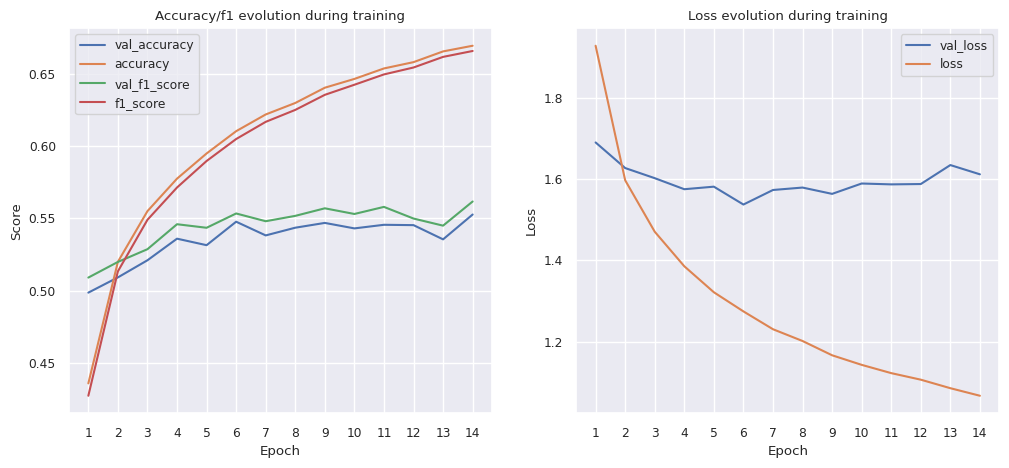

In [ ]:
history = get_full_training_history(model_id,training_history)
if history != None:
  save_training_history(model_id,history)
  #to avoid concat of same history when re-executing this cell
  training_history = None
  plot_training_history(history)

On va maintenant afficher le rapport de classification qui va nous donner une vision détaillée par classe des scores de prédiction.


In [ ]:

print(classification_report(y_test.astype("str"),test_pred_class))


              precision    recall  f1-score   support

          10       0.35      0.46      0.39       311
        1140       0.49      0.61      0.54       267
        1160       0.86      0.88      0.87       396
        1180       0.27      0.30      0.29        76
        1280       0.45      0.29      0.35       487
        1281       0.33      0.25      0.28       207
        1300       0.63      0.62      0.63       505
        1301       0.72      0.54      0.62        81
        1302       0.45      0.49      0.47       249
        1320       0.41      0.48      0.45       324
        1560       0.68      0.44      0.53       507
        1920       0.68      0.84      0.75       431
        1940       0.51      0.70      0.59        81
        2060       0.49      0.43      0.46       499
        2220       0.36      0.33      0.34        82
        2280       0.69      0.62      0.65       476
        2403       0.67      0.44      0.53       477
        2462       0.56    

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

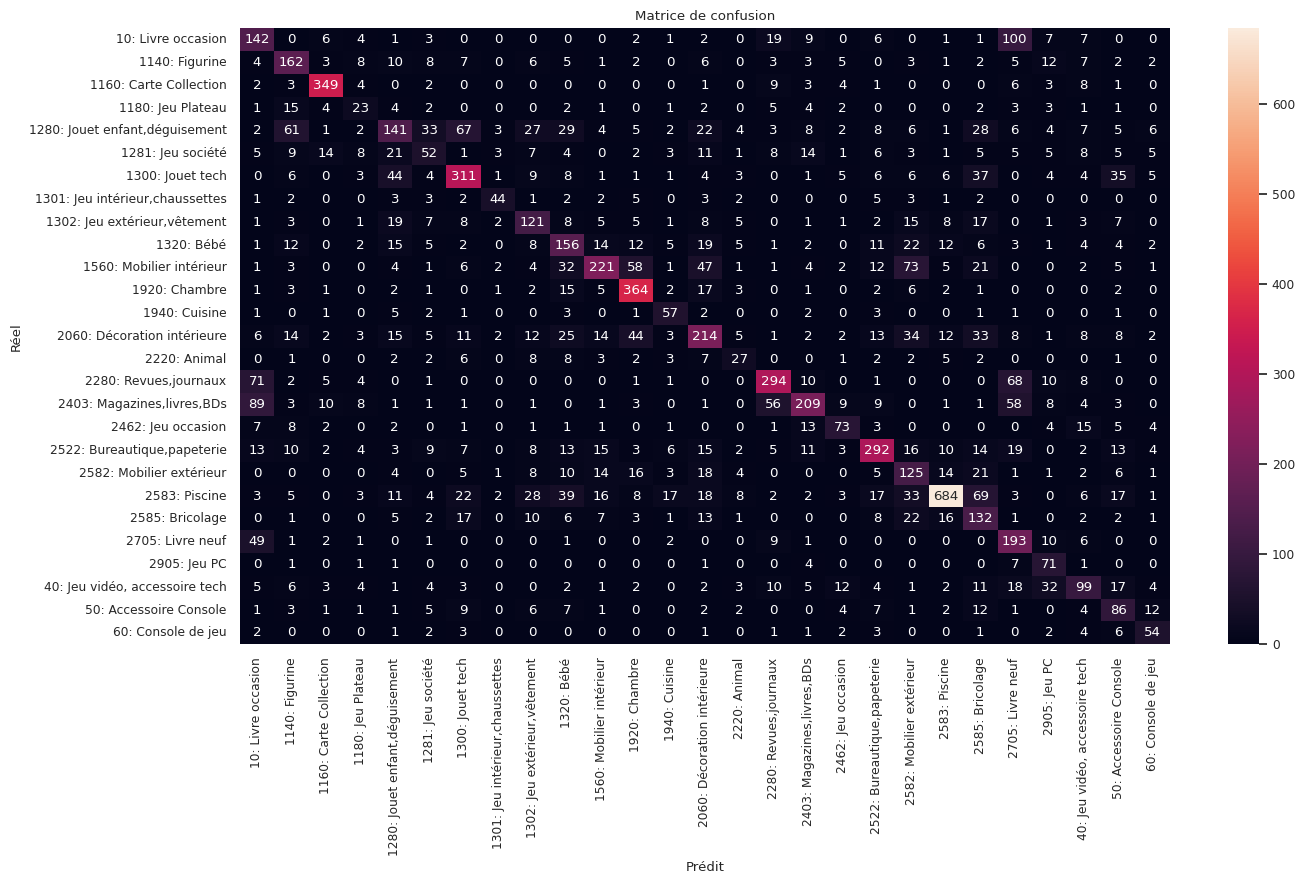

In [ ]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))



## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle.

In [ ]:
reporting_df.loc[model_id].T

model_name                                                            Modèle 3.2
dataset_source                           output/data-exploration/X_train_pre.csv
dataset_resampled                                                          False
image_dataset_source                                             data/images.zip
image_dataset_zoomed                                                       False
train_size                                                              109566.0
image_size                                                                 224.0
image_color_rgb                                                             True
batch_size                                                                  64.0
image_data_generator_params    {'preprocessing_function': 'preprocess_input',...
start_lr                                                                   0.001
last_lr                                                                    0.001
optimizer                   

# Comparaison de tous les modèles du notebook

Comparons maintenant tous les modèles du notebooks.

In [ ]:
model_comparison_cols = ["model_name","dataset_resampled","image_dataset_zoomed",
        "train_size","image_size","batch_size","test_f1_score","test_accuracy",
          "loss","val_loss"]
display(reporting_df.loc[[311,321],model_comparison_cols].T)

model_id,311,321
model_name,Modèle 3.1,Modèle 3.2
dataset_resampled,False,False
image_dataset_zoomed,False,False
train_size,21913.0,109566.0
image_size,224.0,224.0
batch_size,64.0,64.0
test_f1_score,0.514401,0.556558
test_accuracy,0.515191,0.552991
loss,1.433475,1.067026
val_loss,1.707712,1.61175


# Conclusion